In [1]:
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec

Load in all datasets 

In [2]:
historic_flows = np.load('./data/historic_flows.npy')
annual_historic_flows = np.sum(historic_flows, axis=1)*1233.4818/1000000

In [3]:
# load paleo data at Cisco
Paleo = pd.read_csv('./data/Reconstruction/Cisco_Recon_v_Observed_v_Stateline.csv')

# re-scale Cisco data to estimate data at CO-UT state line
factor = np.nanmean(Paleo['ObservedNaturalStateline']/Paleo['ObservedNaturalCisco'])
Paleo['ScaledNaturalCisco'] = Paleo['ObservedNaturalCisco']*factor*1233.4818/1000000
Paleo['ScaledReconCisco'] = Paleo['ReconCisco']*factor*1233.4818/1000000

In [4]:
# Repeat for synthetically generated flows (internal variability of history)
stationary_flows = np.load('./data/stationarysynthetic_flows.npy')*1233.4818/1000000
annual_stationary_flows = np.sum(stationary_flows, axis=2)
annual_stationary_flows_flat = annual_stationary_flows.flatten()

In [5]:
# Repeat for synthetically generated flows (internal variability of paleo)
paleo_flows = np.load('./data/Paleo_SOWs_flows.npy')
paleo_flows_annual = np.sum(paleo_flows, axis=2)*1233.4818/1000000
# Flatten every 10 realizations
paleo_flows_annual_flat = paleo_flows_annual[0*10:0*10+10].flatten()
for i in range(1, 366):
    paleo_flows_annual_flat = np.vstack((paleo_flows_annual_flat, paleo_flows_annual[i*10:i*10+10].flatten()))

In [6]:
# Repeat for all encompassing sample
generated_flows_wider = np.load('./data/LHsamples_wider_100_AnnQonly_flows.npy')
all_annual_experiment_flows = np.sum(generated_flows_wider, axis=2)*1233.4818/1000000
# Flatten every 10 realizations
all_annual_experiment_flat = all_annual_experiment_flows[0*10:0*10+10].flatten()
for i in range(1, 100):
    all_annual_experiment_flat = np.vstack((all_annual_experiment_flat, all_annual_experiment_flows[i*10:i*10+10].flatten()))

In [7]:
#this script tests the effect of window length on drought threshold differences

for window_size in np.arange(10, 90, 10):
    i = 0
    # Initialize an empty list to store moving averages
    moving_windows = []

    # Loop through the array to consider
    # every window of size 3
    while i < len(annual_historic_flows) - window_size + 1:
        # Store elements from i to i+window_size
        # in list to get the current window
        window = annual_historic_flows[i : i + window_size]

        # Store the average of current
        # window in moving average list
        moving_windows.append(window)

        # Shift window to right by one position
        i += 1

    window_means = np.mean(moving_windows, axis=1)
    st_deviations = np.std(moving_windows, axis=1)
    drought_thresholds = window_means-0.5*st_deviations    
    print(window_size, len(moving_windows), drought_thresholds.max()-drought_thresholds.min())

10 96 2849.597646926689
20 86 2212.9620801581705
30 76 1374.2672718790736
40 66 999.8850048103795
50 56 721.595278662001
60 46 448.80981584874826
70 36 381.80772787197657
80 26 497.79614826523084


In [8]:
window_size = 30
i = 0
# Initialize an empty list to store moving averages
moving_windows = []

# Loop through the array to consider
# every window of size 3
while i < len(annual_historic_flows) - window_size + 1:
    # Store elements from i to i+window_size
    # in list to get the current window
    window = annual_historic_flows[i : i + window_size]

    # Store the average of current
    # window in moving average list
    moving_windows.append(window)

    # Shift window to right by one position
    i += 1

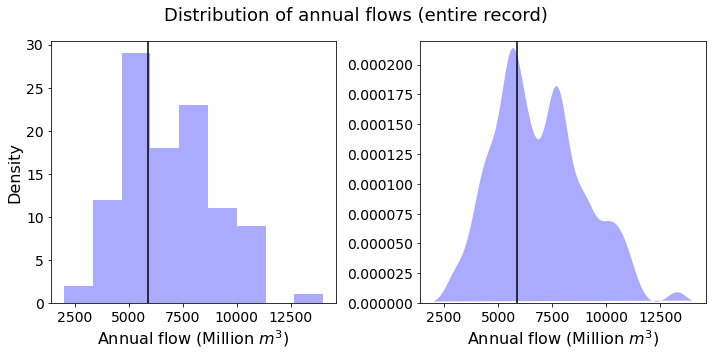

In [9]:
# ----------------------------------------------------------------------
# Plot the progression of histograms to kernels
X = annual_historic_flows
X_plot = np.linspace(2000, 14000, 1000)
bins = np.linspace(2000, 14000, 10)

fig, ax = plt.subplots(1, 2, figsize=(10,5))
# histogram 1
ax[0].hist(X, bins=bins, fc="#AAAAFF", density=False)

# Scipy KDE
kde_sp = gaussian_kde(X, bw_method=0.2)
y_sp = kde_sp.pdf(X_plot)
ax[1].fill(X_plot, y_sp, fc="#AAAAFF")
ax[0].tick_params(axis='both', labelsize=14)
ax[1].tick_params(axis='both', labelsize=14)
ax[0].set_ylabel("Density", fontsize=16)
ax[0].set_xlabel("Annual flow (Million $m^3$)", fontsize=16)
ax[1].set_xlabel("Annual flow (Million $m^3$)", fontsize=16)
drought_threshold = np.mean(annual_historic_flows)-0.5*np.std(annual_historic_flows)
ax[0].axvline(x=drought_threshold, c='black')
ax[1].axvline(x=drought_threshold, c='black')
ax[1].set_ylim(0, 0.00022)
fig.suptitle('Distribution of annual flows (entire record)',  fontsize=18)
fig.tight_layout() 
plt.savefig('annual_flow_dist.svg')

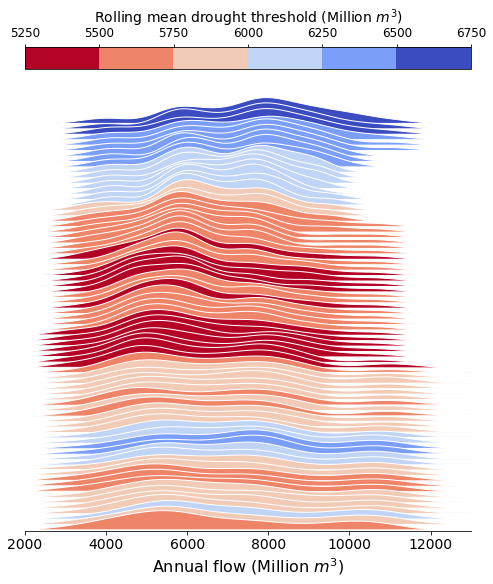

In [10]:
#moving_windows = np.array_split(annual_historic_flows, 5)

gs = (grid_spec.GridSpec(len(moving_windows),1))

fig = plt.figure(figsize=(8,10))

i = 0

#creating empty list
ax_objs = []

window_means = np.mean(moving_windows, axis=1)
st_deviations = np.std(moving_windows, axis=1)
drought_thresholds = window_means-0.5*st_deviations
cmap = mpl.cm.coolwarm_r
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
# define the bins and normalize
bounds = np.linspace(5250, 6750, 7)
normalize = mpl.colors.BoundaryNorm(bounds, cmap.N)
spines = ["top","right","left","bottom"]

for window in moving_windows:
    # creating new axes object and appending to ax_objs
    ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))

    kde_sp = gaussian_kde(window, bw_method=0.3)
    y_sp = kde_sp.pdf(X_plot)
    ax_objs[-1].fill(X_plot, y_sp, fc=cmap(normalize(drought_thresholds[i])), edgecolor='white')

    # setting uniform x and y lims
    ax_objs[-1].set_xlim(2000, 13000)
    ax_objs[-1].set_ylim(0, 0.0005)
    
    # make background transparent
    rect = ax_objs[-1].patch
    rect.set_alpha(0)

    # remove borders, axis ticks, and labels
    ax_objs[-1].set_yticklabels([])
    ax_objs[-1].set_ylabel('')

    for s in spines:
        ax_objs[-1].spines[s].set_visible(False)
        
    if i == len(moving_windows)-1:
        ax_objs[-1].tick_params(axis='x', labelsize=14)
        ax_objs[-1].set_xlabel("Annual flow (Million $m^3$)", fontsize=16)
        ax_objs[-1].spines["bottom"].set_visible(True)
    else:
        ax_objs[-1].set_xticks([])
        ax_objs[-1].set_xticklabels([])
    
    ax_objs[-1].set_yticks([])

    i += 1

gs.update(hspace=-0.9)

# assign cmap and norm
sm = plt.cm.ScalarMappable(cmap=cmap, norm=normalize)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax_objs, location='top', ticks=np.linspace(5250, 7500, 10), pad=0)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Rolling mean drought threshold (Million $m^3$)', fontsize=14)
plt.savefig('rolling_window_thresholds.svg')
plt.show()

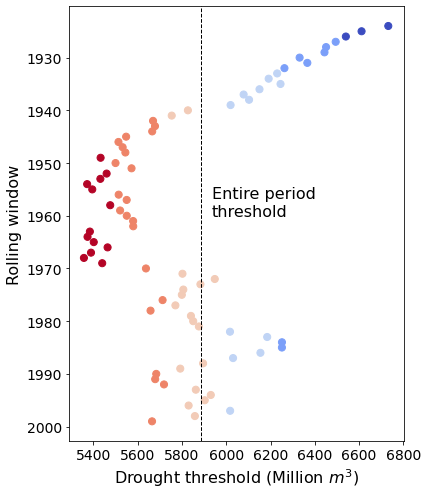

In [11]:
mean_flow = np.mean(annual_historic_flows)
st_deviation = np.std(annual_historic_flows)
drought_threshold = mean_flow-0.5*st_deviation

years = np.arange(1909+(window_size/2), 1909+(window_size/2)+(106-window_size))
plt.figure(figsize=(6,8))
plt.scatter(drought_thresholds, years, s=50, c=cmap(normalize(drought_thresholds)))
plt.axvline(x=drought_threshold, color='k', linewidth=1, linestyle = '--')
plt.text(drought_threshold+50, 1960, "Entire period\nthreshold", fontsize=16)
plt.ylabel("Rolling window", fontsize = 16)
plt.xlabel("Drought threshold (Million $m^3$)", fontsize = 16)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.gca().invert_yaxis()
plt.savefig('rolling_window_thresholds_scatter.svg')
plt.show()

Percent of years crossing the threshold in each realization

In [12]:
drought_thresholds[-1]

5665.05821028973

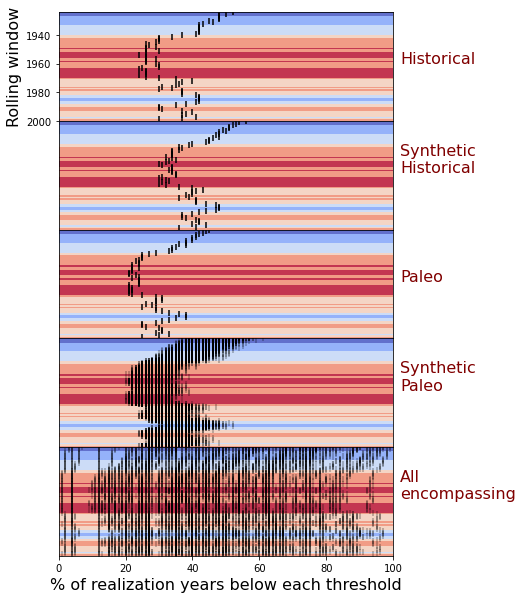

In [13]:
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(6,10))
dataset_names = ["Historical", "Synthetic\nHistorical", "Paleo", "Synthetic\nPaleo", "All\nencompassing"]
datasets = [annual_historic_flows, annual_stationary_flows_flat, Paleo['ScaledReconCisco'][:429]]
multi_datasets = [paleo_flows_annual_flat, all_annual_experiment_flat]

for axis in ax:
    for x in range(len(drought_thresholds)):
        axis.axhspan(years[x], years[x]+1, facecolor=cmap(normalize(drought_thresholds[x])), alpha=0.8)

for j, data in enumerate(datasets):
    percents = [np.around((data <= x).sum(axis=0)/(len(data))*100, decimals=0) 
                     for x in drought_thresholds]
    ax[j].scatter(percents, years, marker = '|', color = 'black', zorder=100)
    #ax[j].set_ylabel('Rolling window', fontsize=14)
    ax[j].set_xticks([])
    ax[j].set_yticks([])
    ax[j].invert_yaxis()
    ax[j].text(102, 1960, dataset_names[j], fontsize=16, color='maroon')
for j, data in enumerate(multi_datasets):
    for x in range(len(drought_thresholds)):
        percents = [np.around((data[i,:] <= drought_thresholds[x]).sum(axis=0)/
                                    (len(data[0,:]))*100, decimals=0) 
                          for i in range(len(data))] 
        ax[j+3].scatter(percents, [int(years[x])]*len(data), marker = '|', 
                        color = 'black', alpha=0.3, zorder=100+x)
    if j==0:
        ax[j+3].set_xticks([])
    ax[j+3].text(102, 1960, dataset_names[j+3], fontsize=16, color='maroon')
    ax[j+3].set_yticks([])
    ax[j+3].invert_yaxis()
    
ax[4].set_xlabel("% of realization years below each threshold", fontsize=16)
ax[0].set_ylabel("Rolling window", fontsize=16)
ax[0].set_yticks(np.arange(1940, 2020,20))


# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (0, 100)
custom_ylim = (2000, 1924)

# Setting the values for all axes.
plt.setp(ax, xlim=custom_xlim, ylim=custom_ylim)
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('years_below_threshold.svg', dpi=300,bbox_inches='tight')
plt.show()

CDFs of flows in each set

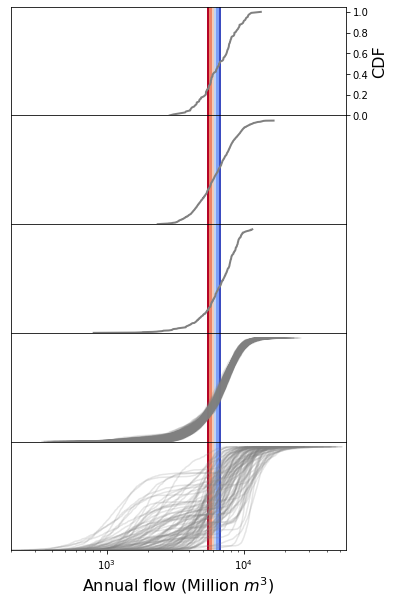

In [14]:
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(6,10), sharex=True)
for j, data in enumerate(datasets):
    for x in drought_thresholds:
        ax[j].axvline(x, color = cmap(normalize(x)), lw = 1)
    sorted_data = np.sort(data)
    yvals=np.arange(len(sorted_data))/float(len(sorted_data)-1)
    ax[j].plot(sorted_data, yvals, lw = 2, color='grey')
    ax[j].set_yticks([])
for j, data in enumerate(multi_datasets):
    for x in drought_thresholds:
        ax[j+3].axvline(x, color = cmap(normalize(x)), lw = 1)
    for i in range(len(data)):
        sorted_data = np.sort(data[i,:])
        yvals=np.arange(len(sorted_data))/float(len(sorted_data)-1)
        ax[j+3].plot(sorted_data, yvals, color = 'grey', alpha = 0.2)
    if j==0:
        ax[j+3].set_xticks([])
    ax[j+3].set_yticks([])
    
ax[4].set_xlabel("Annual flow (Million $m^3$)", fontsize=16)
ax[0].set_ylabel("CDF", fontsize=16)
ax[0].set_yticks(np.arange(0,1.2,0.2))
ax[0].yaxis.tick_right()
ax[0].yaxis.set_label_position("right")

# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (200, 55000)
custom_ylim = (0, 1.05)

# Setting the values for all axes.
plt.setp(ax, xlim=custom_xlim, ylim=custom_ylim, xscale='log')
plt.subplots_adjust(wspace=0, hspace=0)

Distributions of flows in each set

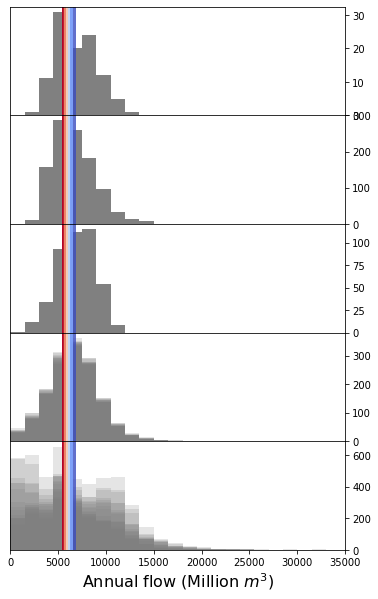

In [15]:
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(6,10))
bins = np.arange(0, 63000, 1500)
for j, data in enumerate(datasets):
    ax[j].hist(data, bins=bins, color='grey')
    ax[j].yaxis.tick_right()
    ax[j].set_xticks([])
    for x in drought_thresholds:
        ax[j].axvline(x, color = cmap(normalize(x)), lw = 1, alpha = 0.8)
for j, data in enumerate(multi_datasets):
    for i in range(len(data)):
        ax[j+3].hist(data[i,:], bins=bins, color='grey', alpha = 0.2)
    for x in drought_thresholds:
        ax[j+3].axvline(x, color = cmap(normalize(x)), lw = 1, alpha = 0.8)
    if j==0:
        ax[j+3].set_xticks([])
    ax[j+3].yaxis.tick_right()
    
ax[4].set_xlabel("Annual flow (Million $m^3$)", fontsize=16)

# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (0, 35000)

# Setting the values for all axes.
plt.setp(ax, xlim=custom_xlim)
plt.subplots_adjust(wspace=0, hspace=0)

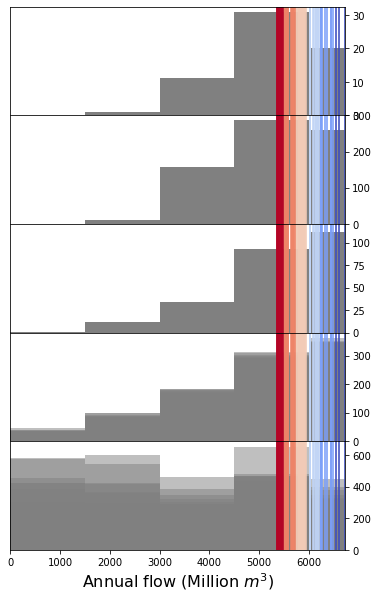

In [16]:
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(6,10))
bins = np.arange(0, 63000, 1500)
for j, data in enumerate(datasets):
    ax[j].hist(data, bins=bins, color='grey')
    ax[j].yaxis.tick_right()
    ax[j].set_xticks([])
    for x in drought_thresholds:
        ax[j].axvline(x, color = cmap(normalize(x)), lw = 2, alpha = 0.8)
for j, data in enumerate(multi_datasets):
    for i in range(len(data)):
        ax[j+3].hist(data[i,:], bins=bins, color='grey', alpha = 0.5)
    for x in drought_thresholds:
        ax[j+3].axvline(x, color = cmap(normalize(x)), lw = 2, alpha = 0.8)
    if j==0:
        ax[j+3].set_xticks([])
    ax[j+3].yaxis.tick_right()
    
ax[4].set_xlabel("Annual flow (Million $m^3$)", fontsize=16)

# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (0, np.max(drought_thresholds))

# Setting the values for all axes.
plt.setp(ax, xlim=custom_xlim)
plt.subplots_adjust(wspace=0, hspace=0)

Text(0.5, 0, 'Year')

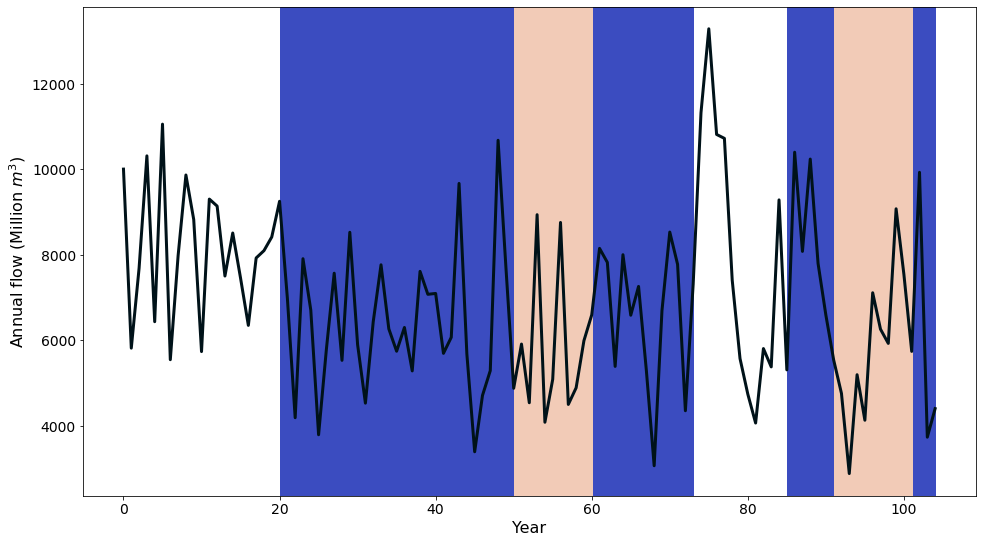

In [17]:
import math

thresholds = [drought_thresholds[0], drought_threshold, drought_thresholds[-1]]
timeseries = annual_historic_flows
drought_colors = ['#CA6702', '#EE9B00']
all_years = len(timeseries)

fig = plt.figure(figsize=(16, 9))

gspec = fig.add_gridspec(ncols=1, nrows=1)
ax = fig.add_subplot(gspec[0, 0])
ax.plot(np.arange(all_years), timeseries, linewidth=3, color='#001219')

for w in range(len(thresholds)):
    color = cmap(normalize(thresholds[w]))
    window_size = 11
    # Calculate rolling means for each drought window
    i = 0
    # Initialize an empty list to store moving averages
    moving_averages = []

    # Loop through the array to consider
    # every window
    while i < len(timeseries) - window_size + 1:
        # Store elements from i to i+window_size
        # in list to get the current window
        window = timeseries[i: i + window_size]

        # Calculate the average of current window
        window_average = round(sum(window) / window_size, 2)

        # Store the average of current
        # window in moving average list
        moving_averages.append(window_average)

        # Shift window to right by one position
        i += 1

    # Plot results
    half_window = math.floor(window_size / 2)
    highlight_years = np.arange(half_window, all_years - half_window)[moving_averages < thresholds[w]]
    all_drought_years_in_window = []
    for year in highlight_years:
        first_year = year - half_window
        last_year = year + half_window
        all_drought_years_in_window.extend(np.arange(first_year, last_year + 1))
        # the window to highlight is +/- 5 years from the identified year crossing the threshold
        ax.axvspan(first_year, last_year, color=color)
        #         ax.plot(np.arange(half_window, all_years-half_window),
        #                 moving_averages, linewidth=3, color='grey', label=f'{window_size}-yr mean')
ax.tick_params(axis='both', labelsize=14)
ax.set_ylabel("Annual flow (Million $m^3$)", fontsize=16)
ax.set_xlabel("Year", fontsize=16)
#ax.legend(fontsize=16, loc='upper right')

# Show changes in flow distributions for key realizations, as compared to history. These are all NATURALIZED FLOWS, not model output

In [ ]:
variable_persistent = 412
persistent_droughts = 82
droughts_variable = 112

plt.figure(figsize=(12,8))
ax = plt.subplot()
ax.hist(annual_historic_flows, align='mid', histtype='stepfilled', facecolor='lightgrey', 
         label='History')

ax.hist(all_annual_experiment_flows[variable_persistent], histtype='step', 
         align='mid', color='#436436', linewidth=4, label='variable_persistent')
ax.hist(all_annual_experiment_flows[persistent_droughts], histtype='step', 
         align='mid', color='#F29A00', linewidth=4, label='persistent_droughts')
ax.hist(all_annual_experiment_flows[droughts_variable], histtype='step', 
         align='mid', color='#774294', linewidth=4, label='droughts_variable')

ax.legend()
ax.set_xlabel('Annual flow (Million $m^3$)', size=16)
ax.set_ylabel('Frequency', size=16)
ax.tick_params(axis='both', labelsize=14)
plt.show()

In [ ]:
from functools import partial

# ----------------------------------------------------------------------
# Plot the progression of histograms to kernels
X = annual_historic_flows
X_plot = np.linspace(0, 18000, 1000)

fig, ax = plt.subplots(1, 2, figsize=(10,5))
# histogram 1
ax[0].hist(annual_historic_flows, align='mid', histtype='stepfilled', facecolor='lightgrey', 
         label='History')

ax[0].hist(all_annual_experiment_flows[variable_persistent], histtype='step', 
         align='mid', color='#436436', linewidth=4, label='variable_persistent')
ax[0].hist(all_annual_experiment_flows[persistent_droughts], histtype='step', 
         align='mid', color='#F29A00', linewidth=4, label='persistent_droughts')
ax[0].hist(all_annual_experiment_flows[droughts_variable], histtype='step', 
         align='mid', color='#774294', linewidth=4, label='droughts_variable')

# Scipy KDE function
def my_kde_bandwidth(obj, fac=1./5):
    """We use Scott's Rule, multiplied by a constant factor. 
    Taken from https://docs.scipy.org/doc/scipy/tutorial/stats.html"""
    return np.power(obj.n, -1./(obj.d+4)) * fac

kde_sp = gaussian_kde(X, bw_method=partial(my_kde_bandwidth, fac=0.4))
y_sp = kde_sp.pdf(X_plot)
ax[1].fill(X_plot, y_sp, fc="lightgrey")

X = all_annual_experiment_flows[variable_persistent]
color = '#436436'
kde_sp = gaussian_kde(X, bw_method=partial(my_kde_bandwidth, fac=0.25))
y_sp = kde_sp.pdf(X_plot)
ax[1].plot(X_plot, y_sp, linewidth=4, color=color)

X = all_annual_experiment_flows[persistent_droughts]
color = '#F29A00'
kde_sp = gaussian_kde(X, bw_method=partial(my_kde_bandwidth, fac=0.4))
y_sp = kde_sp.pdf(X_plot)
ax[1].plot(X_plot, y_sp, linewidth=4, color=color)

X = all_annual_experiment_flows[droughts_variable]
color = '#774294'
kde_sp = gaussian_kde(X, bw_method=partial(my_kde_bandwidth, fac=0.3))
y_sp = kde_sp.pdf(X_plot)
ax[1].plot(X_plot, y_sp, linewidth=4, color=color)

ax[0].axvline(x=drought_thresholds[-1], c='black', linewidth=1, linestyle = '--')
ax[1].axvline(x=drought_thresholds[-1], c='black', linewidth=1, linestyle = '--')

ax[0].tick_params(axis='both', labelsize=14)
ax[1].tick_params(axis='both', labelsize=14)
ax[0].set_ylabel("Frequency", fontsize=16)
ax[1].set_ylabel("Density", fontsize=16)
ax[0].set_xlabel("Annual flow (Million $m^3$)", fontsize=16)
ax[1].set_xlabel("Annual flow (Million $m^3$)", fontsize=16)

fig.tight_layout() 

In [2]:
import statsmodels.api as sm
import seaborn as sns
import scipy.stats as ss
from utils import fitParams

In [3]:
# load paleo data at Cisco
Paleo = pd.read_csv('./data/Reconstruction/Cisco_Recon_v_Observed_v_Stateline.csv')

# re-scale Cisco data to estimate data at CO-UT state line
factor = np.nanmean(Paleo['ObservedNaturalStateline']/Paleo['ObservedNaturalCisco'])
Paleo['ScaledNaturalCisco'] = Paleo['ObservedNaturalCisco']*factor
Paleo['ScaledReconCisco'] = Paleo['ReconCisco']*factor

# compute residual between observed stateline flow and scaled reconstructed flow
Paleo['ScalingResid'] = Paleo['ObservedNaturalStateline'] - Paleo['ScaledReconCisco']
Paleo['FractionScalingResid'] = Paleo['ScalingResid']/Paleo['ScaledReconCisco']

# HMM parameters over the historical record    
trueParams = np.array([[15.258112, 0.259061, 15.661007, 0.252174, 0.679107, 0.649169]])
trueParams = pd.DataFrame({'mu0':trueParams[:,0],'sigma0':trueParams[:,1],\
                           'mu1':trueParams[:,2],'sigma1':trueParams[:,3],\
                           'p00':trueParams[:,4],'p11':trueParams[:,5]})
trueParams['Ensemble'] = 'Observations'

# fit HMM to scaled, reconstructed Cisco flows to represent estimate of flow at state line
# after first adding random errors from residuals of scaled, reconstructed Cisco flows vs. CO-UT state line flows
# repeat 100 times and see how estimates compare with those over the historical record itself
nsims = 100
simParams = np.zeros([nsims,6])
print('calculate std')
stdev = np.std(Paleo['FractionScalingResid'][:429])
print('fit HMM')
for i in range(nsims):
    flows = Paleo['ScaledReconCisco'][:429] + Paleo['ScaledReconCisco'][:429]*ss.norm.rvs(0,stdev,429)
    simParams[i,:] = fitParams(np.array(flows))

# make scatter plot of fitted params to observations (trueParams) compared to
# fitted params to scaled reconstructed flows + residuals (simParams) and their average
meanParams = np.array([np.mean(simParams,0)])
meanParams = pd.DataFrame({'mu0':meanParams[:,0],'sigma0':meanParams[:,1],\
                          'mu1':meanParams[:,2],'sigma1':meanParams[:,3],\
                          'p00':meanParams[:,4],'p11':meanParams[:,5]})
meanParams['Ensemble'] = 'Mean Reconstruction + Noise'

simParams = pd.DataFrame({'mu0':simParams[:,0],'sigma0':simParams[:,1],\
                          'mu1':simParams[:,2],'sigma1':simParams[:,3],\
                          'p00':simParams[:,4],'p11':simParams[:,5]})
simParams['Ensemble'] = 'Reconstruction + Noise'

noNoiseParams = np.array([fitParams(np.array(Paleo['ScaledReconCisco'][:429]))])
noNoiseParams = pd.DataFrame({'mu0':noNoiseParams[:,0],'sigma0':noNoiseParams[:,1],\
                          'mu1':noNoiseParams[:,2],'sigma1':noNoiseParams[:,3],\
                          'p00':noNoiseParams[:,4],'p11':noNoiseParams[:,5]})
noNoiseParams['Ensemble'] = 'Reconstruction'

allParams = pd.concat([simParams,meanParams,noNoiseParams,trueParams], ignore_index=True)
allParams['mu0'] = allParams['mu0'].div(trueParams['mu0'][0])
allParams['sigma0'] = allParams['sigma0'].div(trueParams['sigma0'][0])
allParams['mu1'] = allParams['mu1'].div(trueParams['mu1'][0])
allParams['sigma1'] = allParams['sigma1'].div(trueParams['sigma1'][0])
allParams['p00'] = allParams['p00'].sub(trueParams['p00'][0])
allParams['p11'] = allParams['p11'].sub(trueParams['p11'][0])

print('here')
allParams.to_csv('allParams_2.csv')

calculate std
fit HMM
here


In [4]:
#load LH sample
LH_sample = pd.read_csv('./data/LHsamples_wider_100_AnnQonly.txt', delimiter='\t')
#load drought counts
droughts_df = pd.read_csv('../rival_framings_demand/drought_counts_all_realizations.csv', index_col=0)

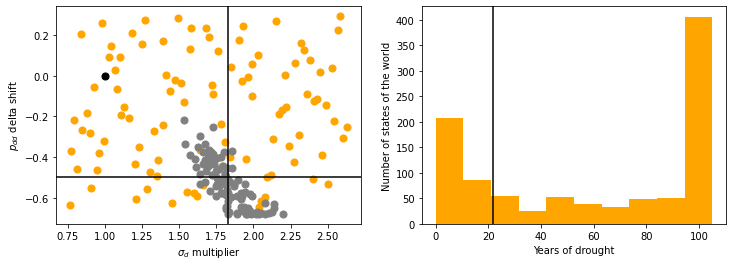

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].scatter(LH_sample['sigma_dry'], LH_sample['p_drydry'], color='orange', s = 50)
axs[0].scatter(simParams['sigma0'].div(trueParams['sigma0'][0]), 
           simParams['p00'].sub(trueParams['p00'][0]), color='grey', s = 50)
axs[0].scatter(1, 0, color='black', s = 50)
axs[0].axhline(y = -0.5, color = 'black', linestyle = '-')
axs[0].axvline(x = 1.83, color = 'black', linestyle = '-')
axs[0].set_ylabel('$p_{dd}$ delta shift')
axs[0].set_xlabel('$\sigma_d$ multiplier')

axs[1].hist(droughts_df['Total counts'], color = 'orange')
axs[1].axvline(x = 22, color = 'black', linestyle = '-')
axs[1].set_ylabel('Number of states of the world')
axs[1].set_xlabel('Years of drought')
plt.savefig('history_thresholds.svg', dpi=300)

In [6]:
allParams

,mu0,sigma0,mu1,sigma1,p00,p11,Ensemble
0,0.984771,2.079659,0.992708,1.094896,-0.626260,0.184443,Reconstruction + Noise
1,0.986357,1.898420,0.993782,1.028063,-0.512255,0.160237,Reconstruction + Noise
2,0.987951,1.753411,0.995383,0.982134,-0.500899,0.096704,Reconstruction + Noise
3,0.993739,1.726028,0.997940,0.912584,-0.253327,0.069985,Reconstruction + Noise
4,0.993586,1.714454,0.995800,0.950606,-0.376043,0.077833,Reconstruction + Noise
...,...,...,...,...,...,...,...
98,0.980969,1.946118,0.992503,1.092034,-0.532903,0.203736,Reconstruction + Noise
99,0.984228,1.915459,0.992748,1.040359,-0.576154,0.160404,Reconstruction + Noise
100,0.986785,1.826141,0.994393,1.023365,-0.529505,0.127768,Mean Reconstruction + Noise
101,0.989881,1.672102,0.995239,0.832756,-0.501050,0.130958,Reconstruction


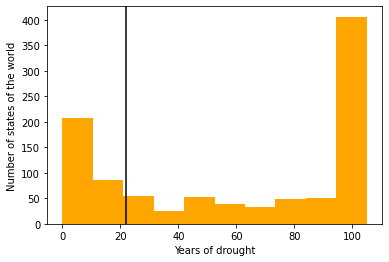